# Notebook objective
- We are going to try to investigate patterns.
- Main questions for the Exploratory Data Analysis (EDA):
    - How many users?
    - How many gyms?
    - How many churns, upgrades, and keep?
    - Do we have the same gyms/users in the application (submission) file?
    - Average usage in months by gyms?
    - Who and how many gyms with top churns?
    - How many users in gyms with top churns?
    - How many users upgraded/keep in gyms with top churns?
    - Average user's age by gyms with top churns?
    - Average usage in months by gyms with top churns?
    - Who are the most loyal users of Gympass? And which gym will undergo the uptier?
    - How each numeric feature affects the class/target (boxplot, histogram)?

# Imports and Functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from typing import Dict, Union
from typing import Optional, Tuple


In [2]:
!pip3 install missingno 
!pip3 install openpyxl

In [3]:
TARGET_FEATURES = ['is_churn', 'is_keep','is_upgrade', 'churn_target', 'multiclass_target', 'churn_target_names', 'multiclass_target_names', 'churn_target']
INDEX_FEATURES = ['gym', 'user', 'communication_date']

In [4]:
from helper import *
%load_ext autoreload
%autoreload 2

# Load data

- The "train.xlxs" here is the past user's data
- The "submission.xlsx" is the "application" file you sent to me.

In [5]:
train_data = pd.read_excel('../data/raw/train.xlsx')
submission_data = pd.read_excel('../data/raw/submission.xlsx')
train_data

,communication_date,gym,gym_category,gym_days_since_first_visit,gym_last_60_days_visits,gyms_5km,is_churn,is_keep,is_upgrade,user,user_age,user_billings,user_days_since_first_billing,user_days_since_first_gym_visit,user_days_since_first_visit,user_last_60_days_visit_share,user_last_60_days_visits,user_lifetime_visit_share,user_lifetime_visits,user_plan
0,2021-10-25,0,bodybuilding,472,3751,35,0,1,0,0,50,13,1833.0,346,1833,5.263158e+15,19,1.170213e+16,94.0,Silver
1,2021-06-20,1,not found,2176,357,7,0,1,0,1,45,87,2608.0,54,1719,1.000000e+00,2,6.153846e+15,325.0,Basic II
2,2021-10-25,2,bodybuilding,895,3132,41,0,1,0,2,27,9,271.0,264,271,1.162791e+16,43,1.206030e+16,199.0,Basic I
3,2021-10-25,3,bodybuilding,896,4775,42,0,1,0,3,29,9,271.0,268,271,1.627907e+16,43,1.557789e+16,199.0,Basic I
4,2021-12-12,4,not found,1516,503,65,0,0,1,4,22,20,729.0,726,726,1.000000e+00,29,1.000000e+00,119.0,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31256,2021-12-04,19,not found,144,14979,28,0,0,1,31256,22,2,25.0,24,24,2.500000e-01,4,2.500000e-01,4.0,Silver
31257,2021-12-04,19,not found,144,14979,28,1,0,0,31257,66,1,19.0,19,19,1.000000e+00,1,1.000000e+00,1.0,Silver
31258,2021-12-11,109,bodybuilding,1062,1466,69,0,1,0,31258,42,1,25.0,12,24,2.500000e-01,8,2.500000e-01,8.0,Silver
31259,2022-01-17,50,crossfit,1500,780,30,0,1,0,31259,37,3,56.0,55,55,5.625000e+03,16,5.625000e+03,16.0,Silver


# Preprocessing

In [6]:
# features
train_data = preprocessing(train_data)

# add names to better v
target_names = {1: 'is_churn', 0: 'is_keep', 2: 'is_upgrade'}

train_data['multiclass_target_names'] = train_data['multiclass_target'].map(target_names)

binary_target_names = {1: 'is_churn', 0: 'is_not_churn'}

train_data['churn_target_names'] = train_data['churn_target'].map(binary_target_names)



# EDA

### Define Features List

In [7]:
FEATURES = get_features(train_data, TARGET_FEATURES, INDEX_FEATURES)
NUMERIC_FEATURES = sorted(get_numerical_features(train_data[FEATURES]))
CATEGORICAL_FEATURES = sorted(get_categorical_features(train_data[FEATURES]))
NUMERIC_FEATURES, CATEGORICAL_FEATURES

(['gym_days_since_first_visit',
  'gym_last_60_days_visits',
  'gym_visit_frequency',
  'gyms_5km',
  'months_usage',
  'user_age',
  'user_age_group',
  'user_days_since_first_billing',
  'user_days_since_first_gym_visit',
  'user_days_since_first_visit',
  'user_engagement',
  'user_last_60_days_visit_share',
  'user_last_60_days_visits',
  'user_lifetime_visit_share',
  'user_lifetime_visits',
  'user_visit_frequency',
  'years_usage'],
 ['gym_category', 'user_plan'])

## Feature correlation
- Features with correlation larger than 0.9:
	- user_days_since_first_visit and user_days_since_first_billing: 0.9543026199267016
	- user_days_since_first_billing and user_days_since_first_visit: 0.9543026199267016
	- years_usage and months_usage: 0.9999999999999943
	- user_visit_frequency and user_last_60_days_visits: 0.939675636174908
	- gym_last_60_days_visits and gym_visit_frequency: 1.0000000000000044
	- user_last_60_days_visits and user_visit_frequency: 0.939675636174908
	- months_usage and years_usage: 0.9999999999999943
	- gym_visit_frequency and gym_last_60_days_visits: 1.0000000000000044

In [37]:
corr = train_data[NUMERIC_FEATURES].corr()


In [38]:
high_correlation = corr[corr > 0.9]

# Iterate over the correlation matrix and print feature pairs with high correlation
print("Features with correlation larger than 0.9:")
for feature1 in high_correlation.columns:
    for feature2 in high_correlation.index:
        correlation = high_correlation.loc[feature2, feature1]
        if not pd.isnull(correlation) and correlation > 0.9 and feature1 != feature2:
            print(f"\t{feature1} and {feature2}: {correlation}")

Features with correlation larger than 0.9:
	gym_last_60_days_visits and gym_visit_frequency: 1.0000000000000044
	gym_visit_frequency and gym_last_60_days_visits: 1.0000000000000044
	months_usage and years_usage: 0.9999999999999941
	user_age and user_age_group: 0.983299941139705
	user_age_group and user_age: 0.983299941139705
	user_days_since_first_billing and user_days_since_first_visit: 0.9543026199267016
	user_days_since_first_visit and user_days_since_first_billing: 0.9543026199267016
	user_last_60_days_visits and user_visit_frequency: 1.0000000000000002
	user_visit_frequency and user_last_60_days_visits: 1.0000000000000002
	years_usage and months_usage: 0.9999999999999941


<Axes: >

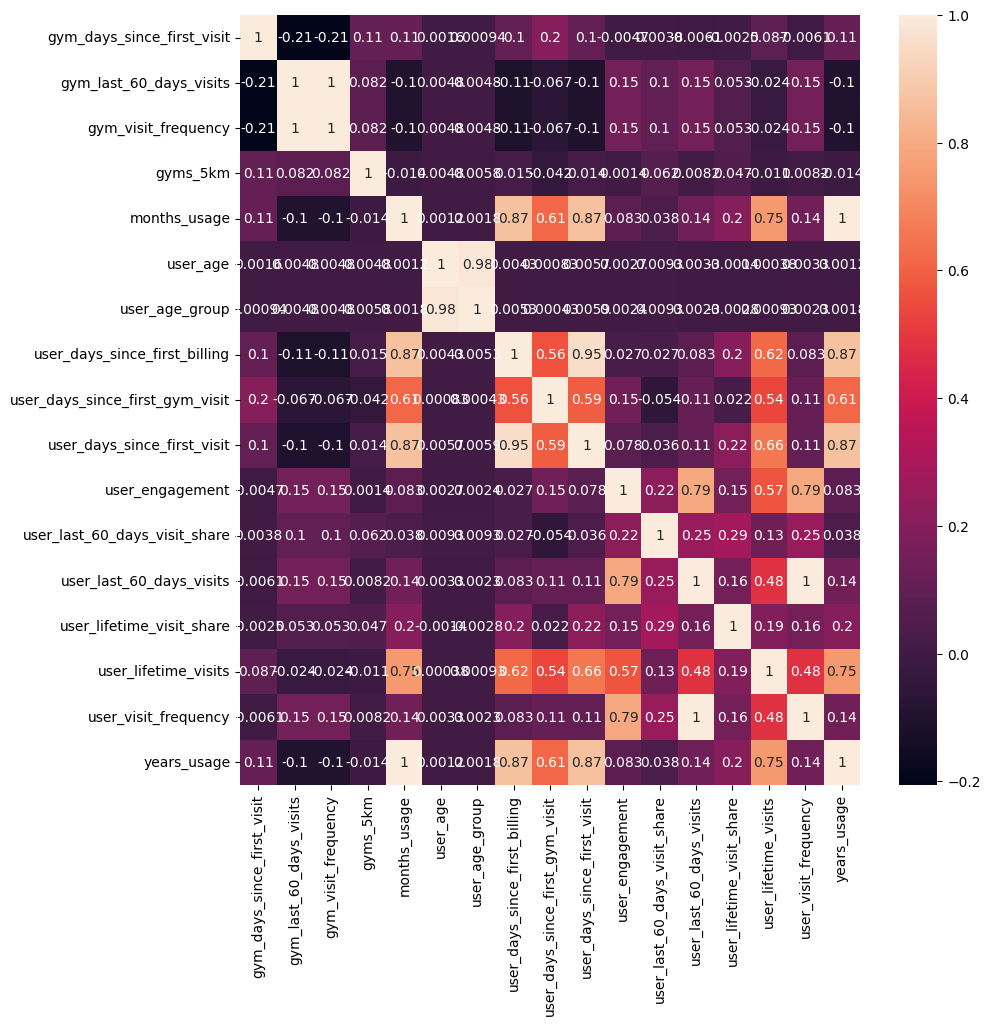

In [40]:

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))
sns.heatmap(corr,
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Number of data points in train data and submission data.

In [41]:
train_data_size = train_data.shape[0]
submission_data_size = submission_data.shape[0]
print(f"Trainining data size {train_data_size}")
print(f"Submission data size {submission_data_size}")

Trainining data size 31261
Submission data size 5556


## How many users in train data and in submission? 

In [ ]:
number_users = train_data.user.unique().shape[0]

print(f" Ratio of users in submission and train size {number_users/train_data_size}")

 Ratio of users in submission and train size 1.0


In [ ]:
number_users_sub = submission_data.user.unique().shape[0]

print(f" Ratio of users in submission and submission size {number_users_sub/submission_data_size}")

 Ratio of users in submission and submission size 1.0


## Do we have the same gyms and users in the submission?

In [ ]:
gym_ids_train = set(train_data.gym.unique())
user_ids_train = set(train_data.user.unique())

gym_ids_sub = set(submission_data.gym.unique())
user_ids_sub = set(submission_data.user.unique())

print(f"Total of gym ids in intersection {len(gym_ids_train.intersection(gym_ids_sub))}")

Total of gym ids in intersection 0


In [ ]:
print(f"Total of gym ids in intersection {len(user_ids_train.intersection(user_ids_sub))}")

Total of gym ids in intersection 0


## How many churns, upgrades, and keep?

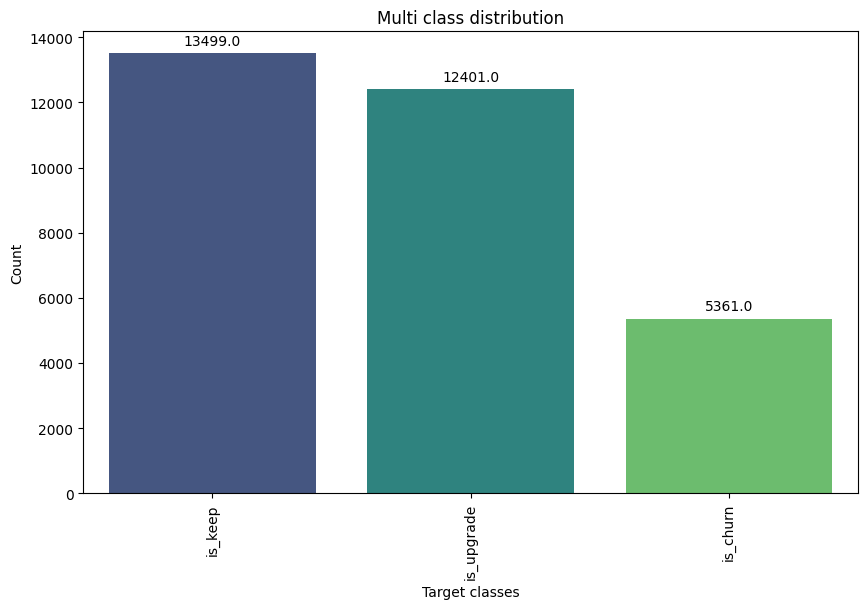

In [ ]:
plot_count(train_data, column='multiclass_target_names', title='Multi class distribution', xlabel = "Target classes", sort=True)

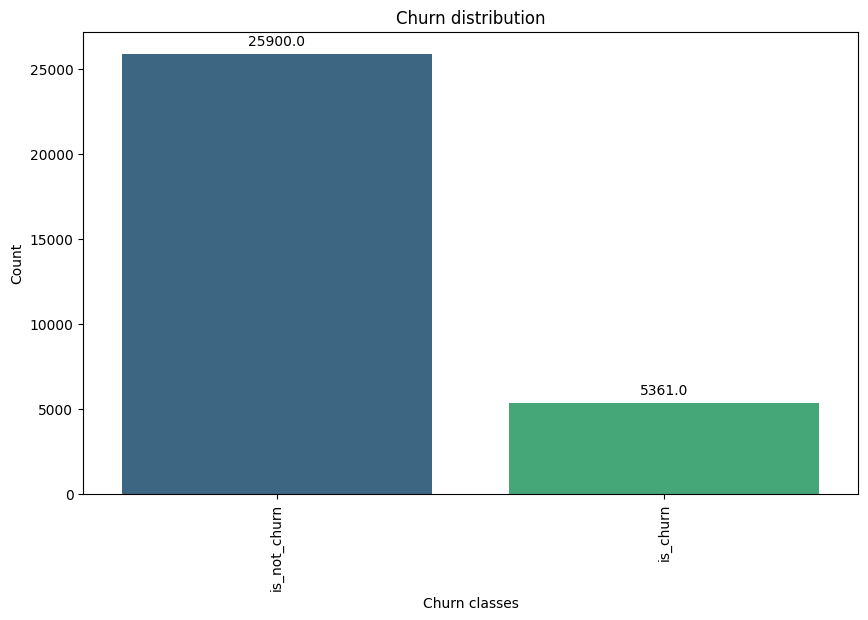

In [9]:
plot_count(train_data, column='churn_target_names', title='Churn distribution', xlabel = "Churn classes", sort=True)

## How distributed is the user_engagement created feature value?

- Non-churn users has lower user_engagement. This means they have more user_billings (more payments)

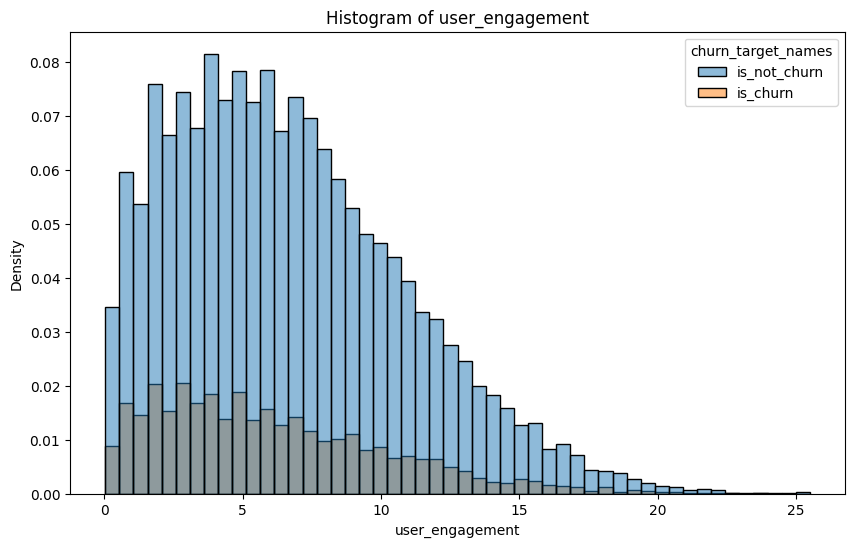

In [10]:
plot_histogram(train_data, 'user_engagement', hue='churn_target_names')

<Axes: xlabel='churn_target_names', ylabel='user_engagement'>

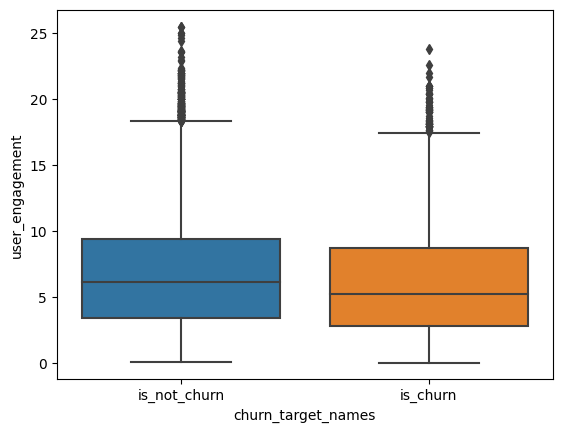

In [11]:
sns.boxplot(data=train_data[FEATURES+ ['churn_target_names']], x='churn_target_names', y='user_engagement')

## How distributed is the gym_visit_frequency and user_visit_frequency created feature value?

<Axes: xlabel='churn_target_names', ylabel='gym_visit_frequency'>

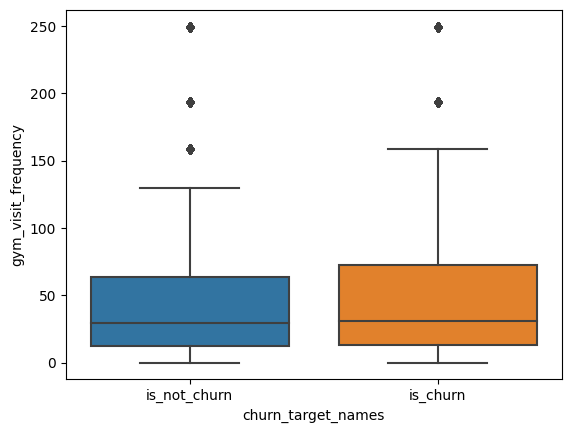

In [12]:
sns.boxplot(data=train_data[FEATURES+ ['churn_target_names']], x='churn_target_names', y='gym_visit_frequency')

<Axes: xlabel='churn_target_names', ylabel='user_visit_frequency'>

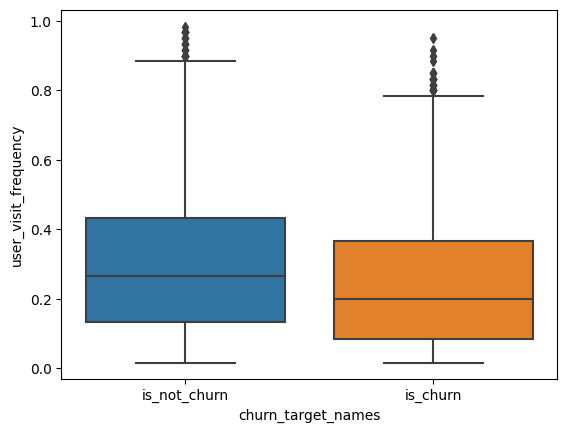

In [13]:
sns.boxplot(data=train_data[FEATURES+ ['churn_target_names']], x='churn_target_names', y='user_visit_frequency')

## What are the gyms with the highest churn rate?

<Axes: >

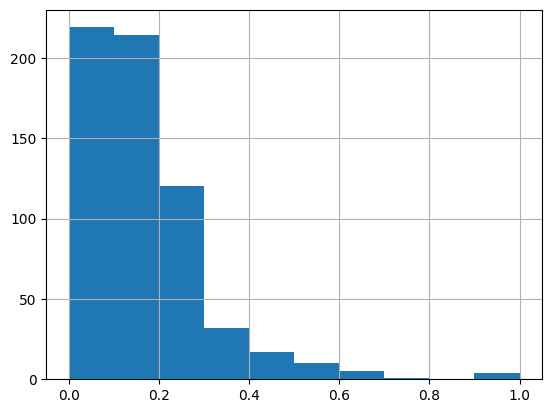

In [14]:
churn_rate = train_data.groupby("gym")['churn_target'].mean().sort_values()
churn_rate.hist()

In [15]:
top_churn_rate_gyms = list(churn_rate[churn_rate > 0.5].index)
print("Total of top churn gyms", len(top_churn_rate_gyms))

Total of top churn gyms 16


In [16]:
# train_data.groupby('churn_target_names').months_usage.mean().plot(kind='bar')
train_data['is_top_churn_gym'] = False
train_data.loc[train_data.gym.isin(top_churn_rate_gyms), 'is_top_churn_gym'] = True

## How is the "top churn gyms" distributions ? How is the distribution in relation of user plan?

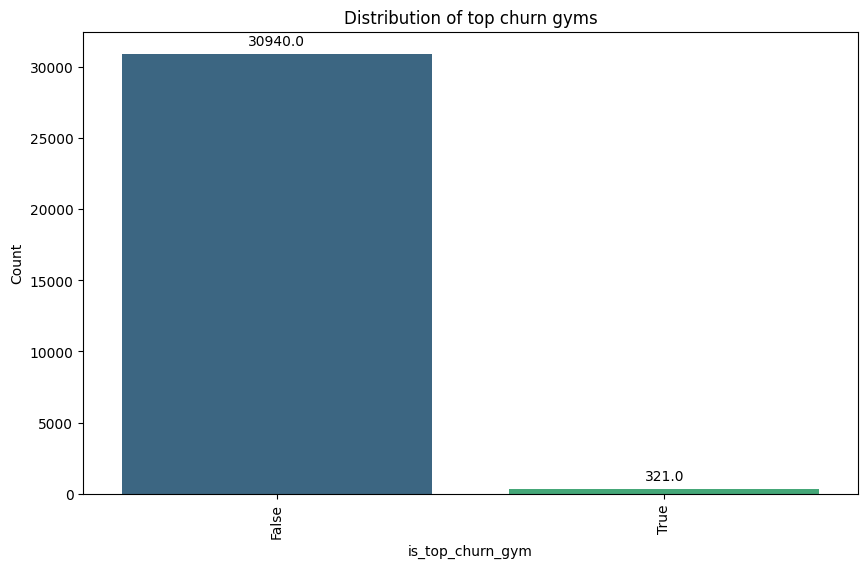

In [17]:
plot_count(train_data, 'is_top_churn_gym', title="Distribution of top churn gyms")

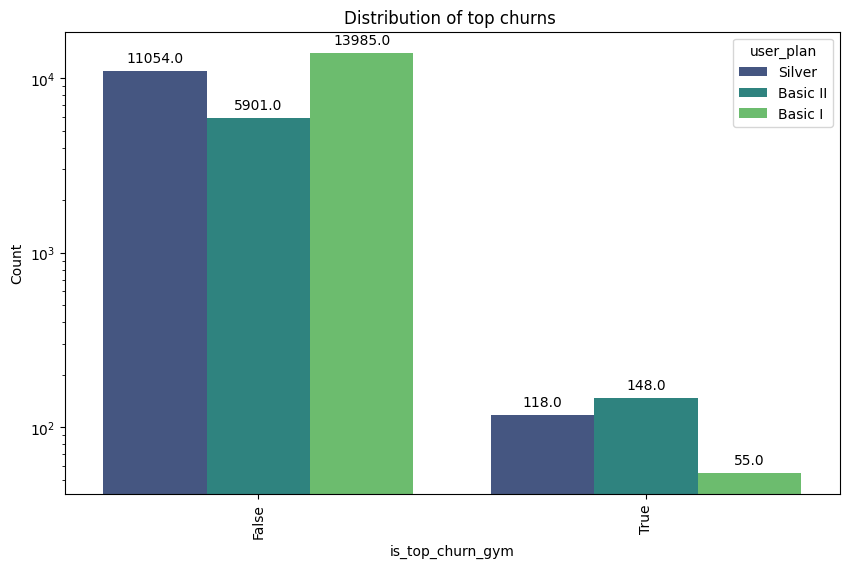

In [18]:
plot_count(train_data, 'is_top_churn_gym', hue='user_plan', log_scale=True, title="Distribution of top churns ")

## How different is the gyms_5km by churn and non-churn groups?

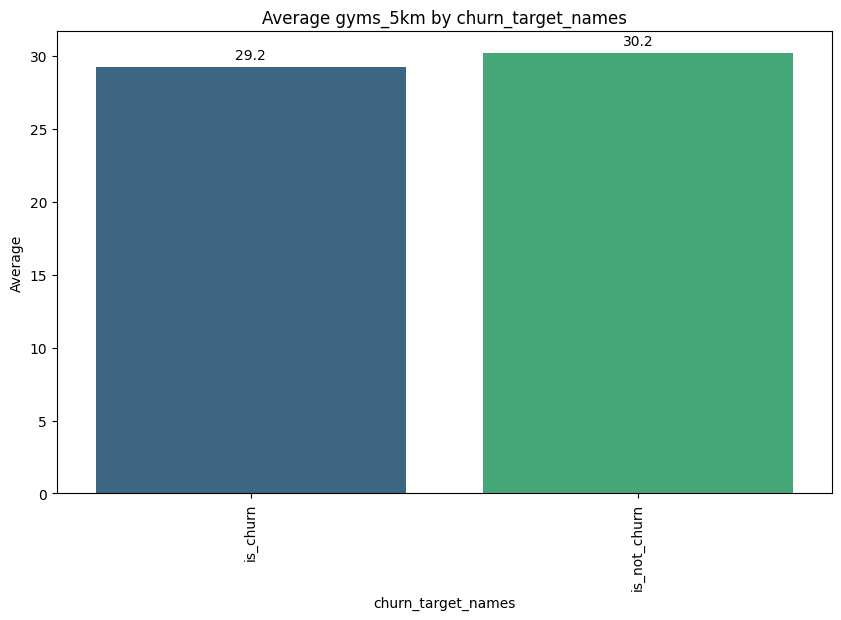

In [19]:
plot_avg(train_data, 'churn_target_names', 'gyms_5km', sort=True)

## How different is the gym_days_since_first_visit by churn and non-churn groups?

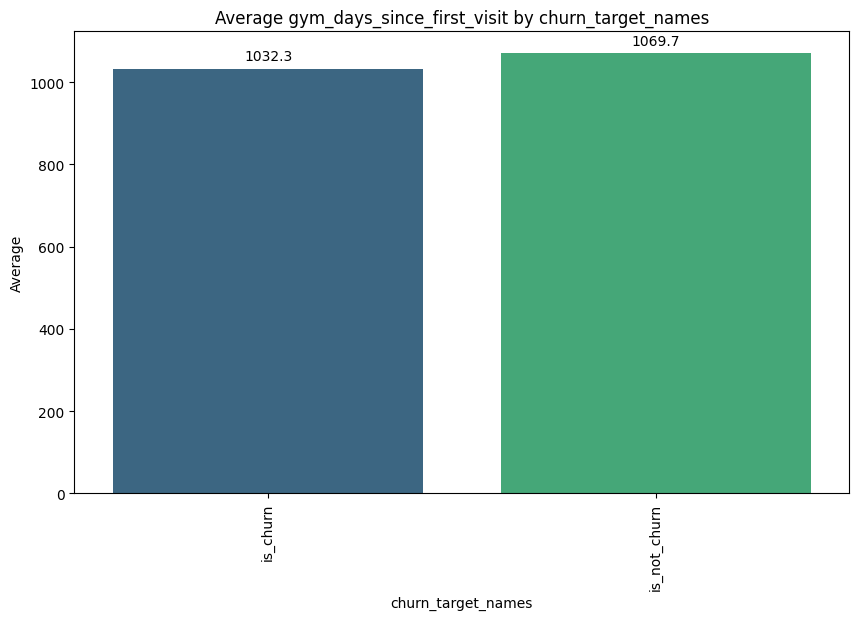

In [20]:
plot_avg(train_data, 'churn_target_names', 'gym_days_since_first_visit', sort=True)

## How different is the gym_last_60_days_visits by churn and non-churn groups?

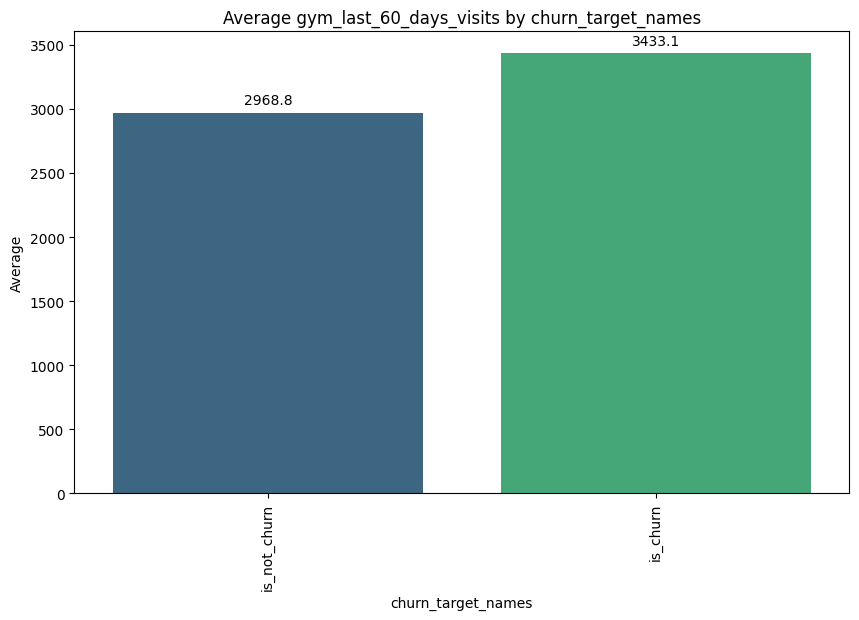

In [21]:
plot_avg(train_data, 'churn_target_names', 'gym_last_60_days_visits', sort=True)

## How different is the months_usage by churn and non-churn groups?

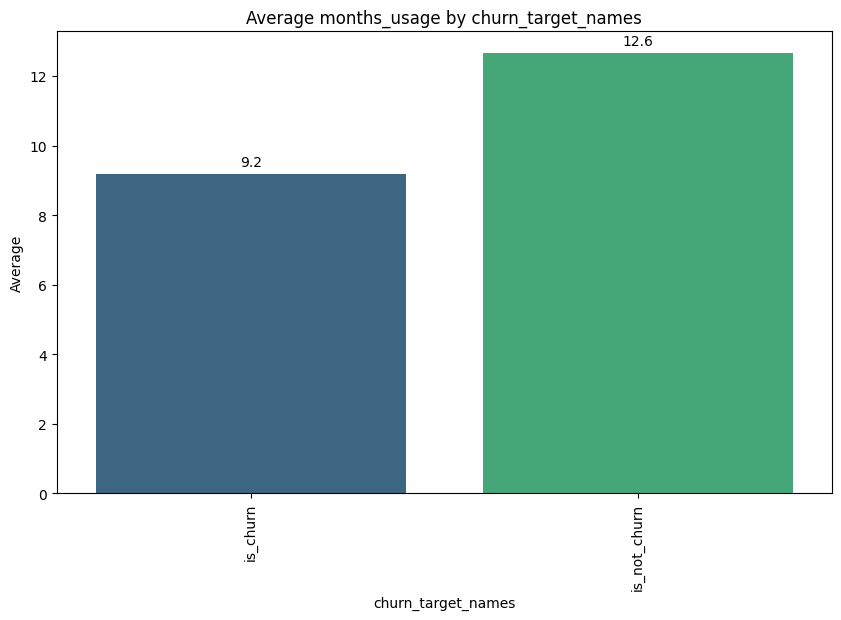

In [22]:
plot_avg(train_data, 'churn_target_names', 'months_usage', sort=True)

## How different is the user_age between by churn and non-churn groups?

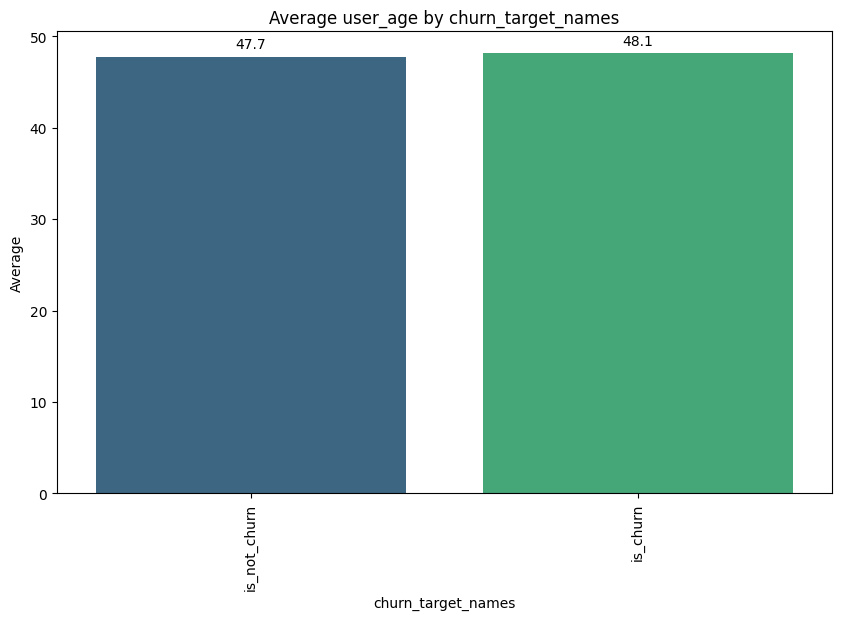

In [23]:
plot_avg(train_data, 'churn_target_names', 'user_age', sort=True)

- Old people give up less

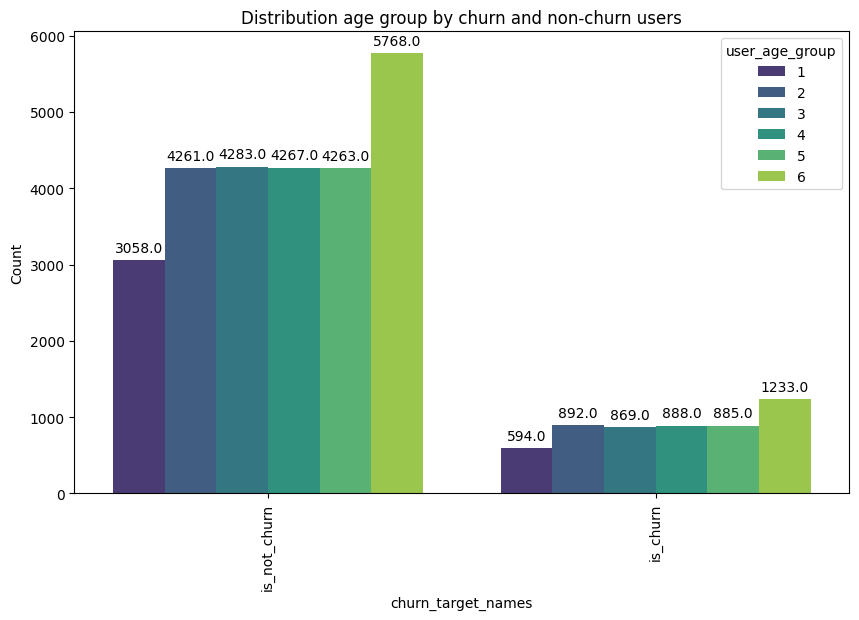

In [24]:
plot_count(train_data, 'churn_target_names', hue='user_age_group', log_scale=False, title="Distribution age group by churn and non-churn users")

## How different is the user_days_since_first_billing by churn and non-churn groups?

- Churn users are more likely to be younger on the platform.

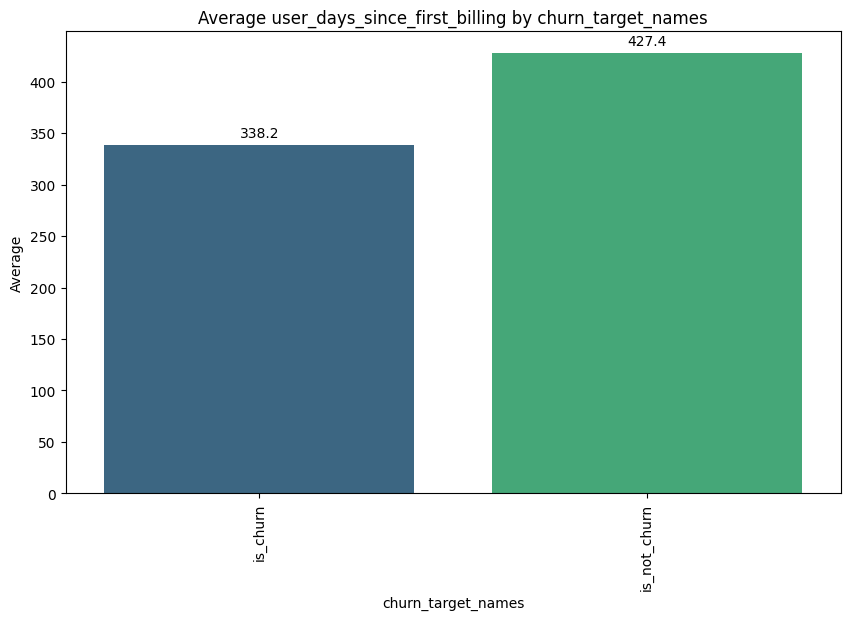

In [25]:
plot_avg(train_data, 'churn_target_names', 'user_days_since_first_billing', sort=True)

## How different is the user_days_since_first_visit by churn and non-churn groups?

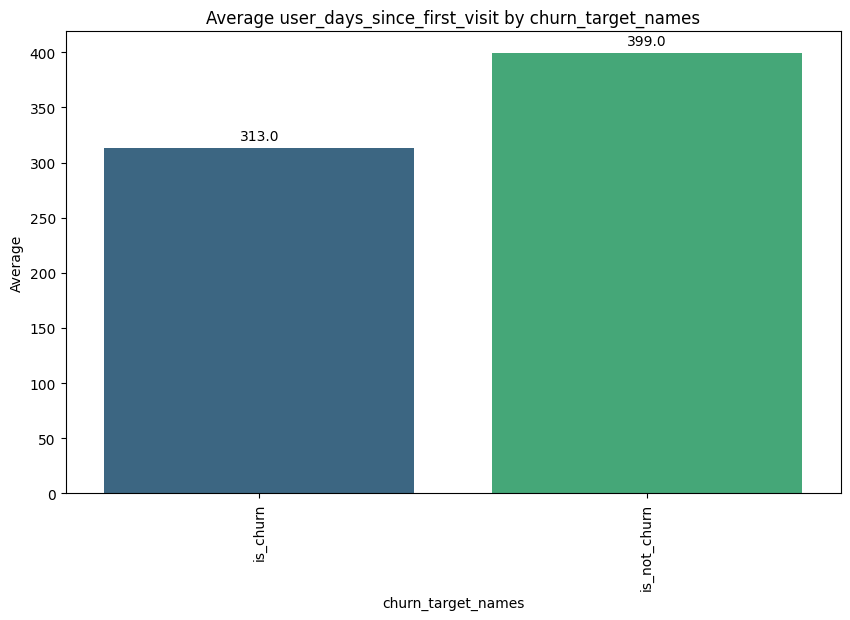

In [26]:
plot_avg(train_data, 'churn_target_names', 'user_days_since_first_visit', sort=True)

# Bivariate pairplot

In [27]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 44.1 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [28]:
from imblearn.under_sampling import RandomUnderSampler

# Assume df is your dataframe and 'target' is your target column
X = train_data[FEATURES]
y = train_data['churn_target_names']

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Concatenate our training data back together
df_res = pd.concat([pd.DataFrame(y_res), pd.DataFrame(X_res)], axis=1)
df_res.head()

,churn_target_names,months_usage,years_usage,gyms_5km,user_age,gym_visit_frequency,gym_category,user_visit_frequency,user_lifetime_visit_share,gym_days_since_first_visit,user_lifetime_visits,user_last_60_days_visit_share,user_plan,user_age_group,user_days_since_first_visit,user_days_since_first_billing,user_last_60_days_visits,user_days_since_first_gym_visit,user_engagement,gym_last_60_days_visits
11,is_churn,48,4.000000,11,27,16.666667,bodybuilding,0.566667,9.892473e+14,2129,558.0,1.000000e+00,Silver,2,1456,2539.0,34.0,1456,11.625000,1000
21,is_churn,22,1.833333,0,70,17.316667,not found,0.016667,6.600000e-01,1131,200.0,1.000000e+00,Basic II,6,1316,1345.0,1.0,871,9.090909,1039
26,is_churn,15,1.250000,35,19,31.000000,bodybuilding,0.250000,1.463415e+16,1168,41.0,6.666667e+15,Basic II,1,1682,1867.0,15.0,522,2.733333,1860
42,is_churn,11,0.916667,29,35,5.583333,functional,0.750000,4.455959e+16,275,193.0,1.111111e+15,Basic I,3,273,273.0,45.0,273,17.545455,335
43,is_churn,6,0.500000,44,53,159.016667,bodybuilding,0.100000,1.000000e+00,747,10.0,1.000000e+00,Basic I,4,138,139.0,6.0,138,1.666667,9541


In [29]:
df_res.churn_target_names.value_counts()

churn_target_names
is_churn        5361
is_not_churn    5361
Name: count, dtype: int64

In [30]:
NUMERIC_FEATURES

['gym_days_since_first_visit',
 'gym_last_60_days_visits',
 'gym_visit_frequency',
 'gyms_5km',
 'months_usage',
 'user_age',
 'user_age_group',
 'user_days_since_first_billing',
 'user_days_since_first_gym_visit',
 'user_days_since_first_visit',
 'user_engagement',
 'user_last_60_days_visit_share',
 'user_last_60_days_visits',
 'user_lifetime_visit_share',
 'user_lifetime_visits',
 'user_visit_frequency',
 'years_usage']

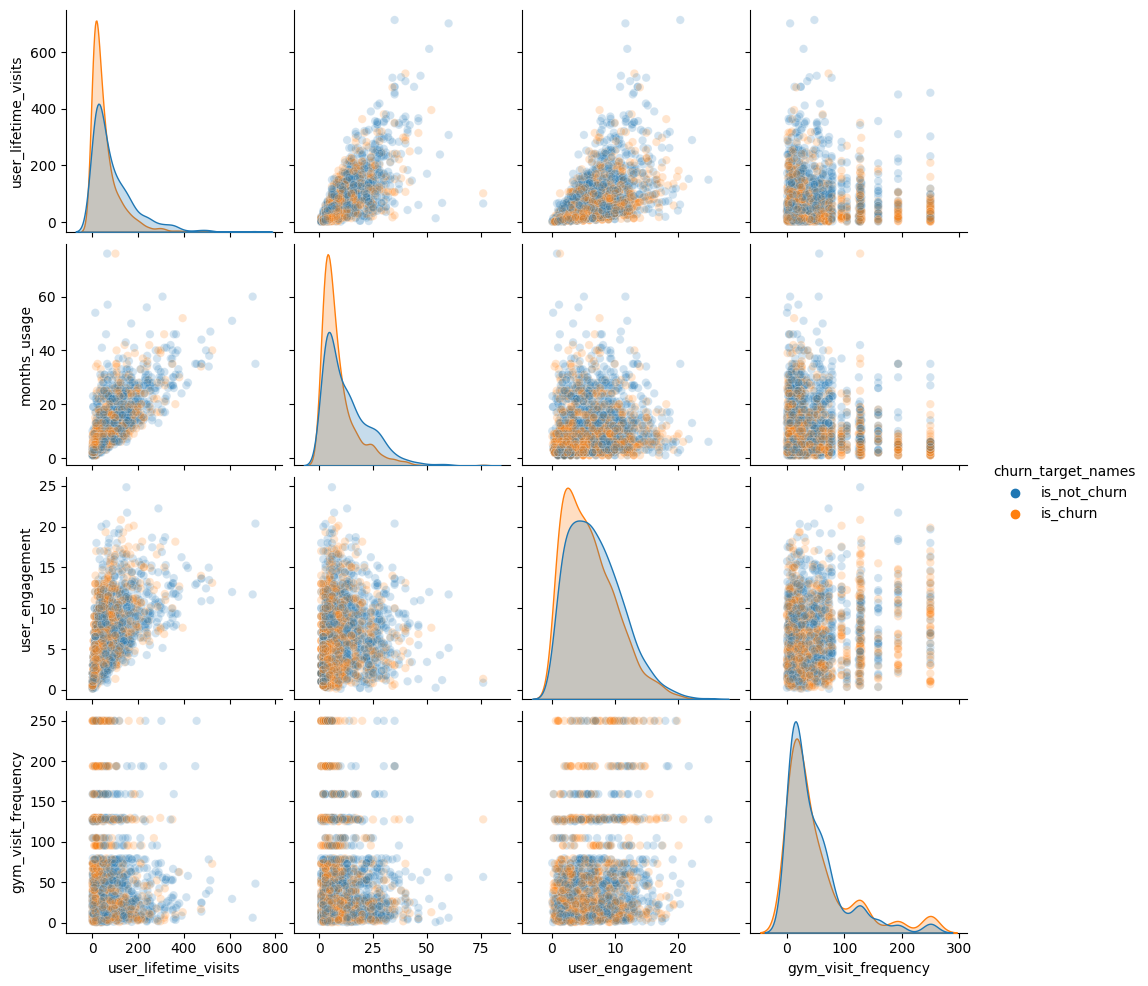

In [31]:
sns.pairplot(df_res[['user_lifetime_visits', 'months_usage', 'user_engagement', 'gym_visit_frequency'] + ['churn_target_names']].sample(2000), hue='churn_target_names', plot_kws={'alpha':0.2})

- trying to create 'loyalty' features

In [32]:
NUMERIC_FEATURES

['gym_days_since_first_visit',
 'gym_last_60_days_visits',
 'gym_visit_frequency',
 'gyms_5km',
 'months_usage',
 'user_age',
 'user_age_group',
 'user_days_since_first_billing',
 'user_days_since_first_gym_visit',
 'user_days_since_first_visit',
 'user_engagement',
 'user_last_60_days_visit_share',
 'user_last_60_days_visits',
 'user_lifetime_visit_share',
 'user_lifetime_visits',
 'user_visit_frequency',
 'years_usage']

In [33]:
# remove _share features as it hard to understand
FEATURES_ANALYZE = [k for k in NUMERIC_FEATURES if '_share' not in k]

In [34]:
FEATURES_ANALYZE

['gym_days_since_first_visit',
 'gym_last_60_days_visits',
 'gym_visit_frequency',
 'gyms_5km',
 'months_usage',
 'user_age',
 'user_age_group',
 'user_days_since_first_billing',
 'user_days_since_first_gym_visit',
 'user_days_since_first_visit',
 'user_engagement',
 'user_last_60_days_visits',
 'user_lifetime_visits',
 'user_visit_frequency',
 'years_usage']

# Plotting features vs target

### BoxPlot

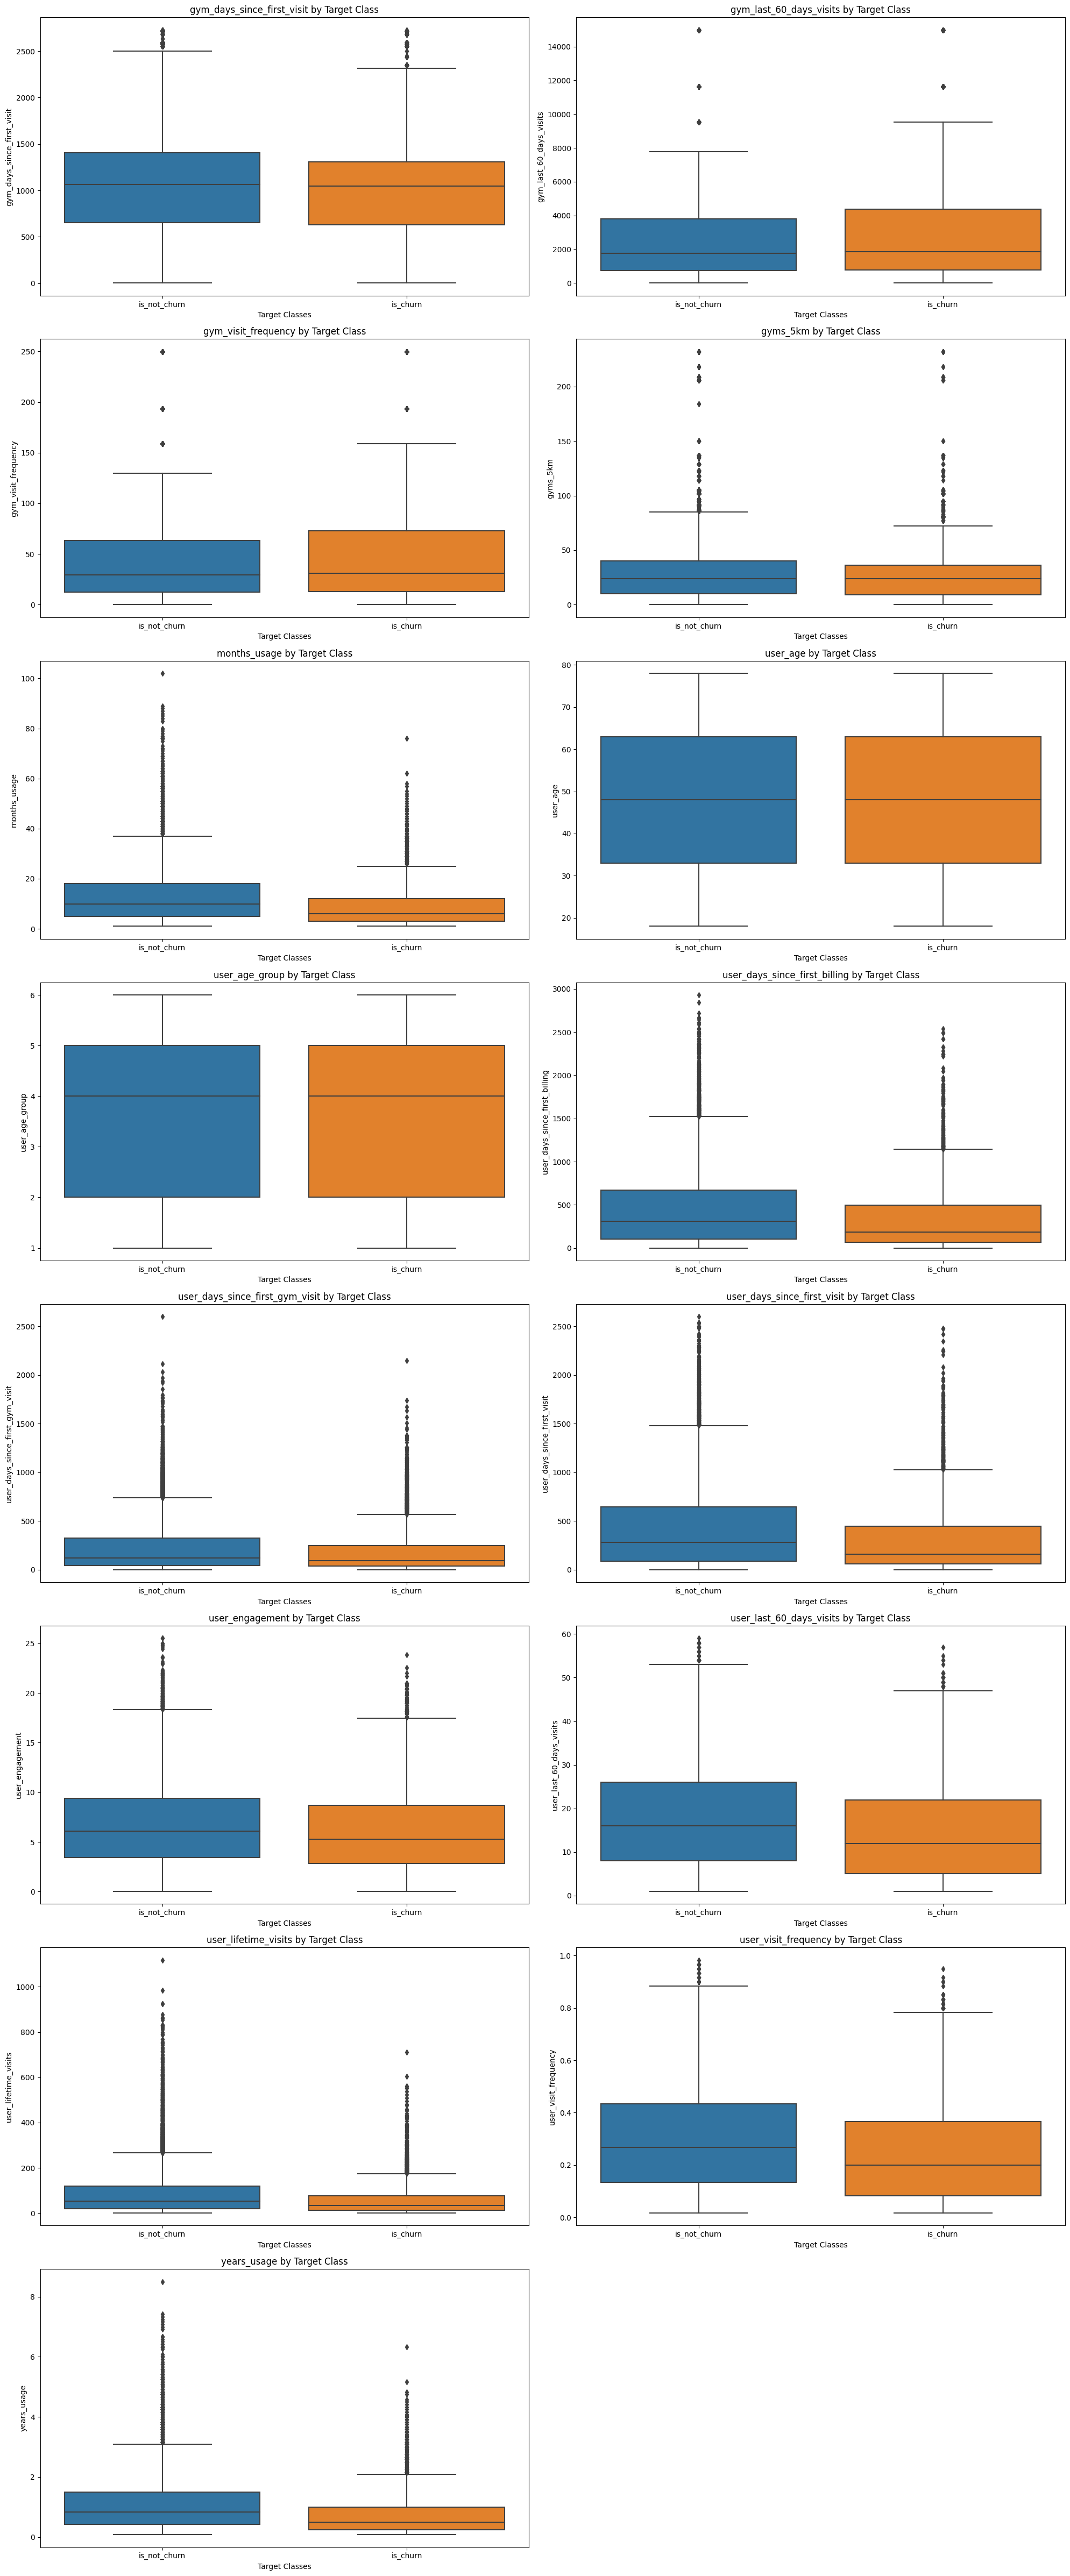

In [35]:
import math

# calculate the number of rows and columns needed for the subplots
num_vars = len(FEATURES_ANALYZE)
num_cols = 2  # adjust as needed
num_rows = math.ceil(num_vars / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows*6))

for i, numeric_var in enumerate(FEATURES_ANALYZE):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    sns.boxplot(data=train_data[FEATURES_ANALYZE + ['churn_target_names']], x='churn_target_names', y=numeric_var, ax=ax)
    ax.set_title(f'{numeric_var} by Target Class')
    ax.set_xlabel('Target Classes')
    ax.set_ylabel(f"{numeric_var}")

# Remove unused subplots
if num_rows * num_cols > num_vars:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
# Save the figure
plt.savefig('viz/numeric_features_binary_box_plot.png')

plt.show()

### Histograms

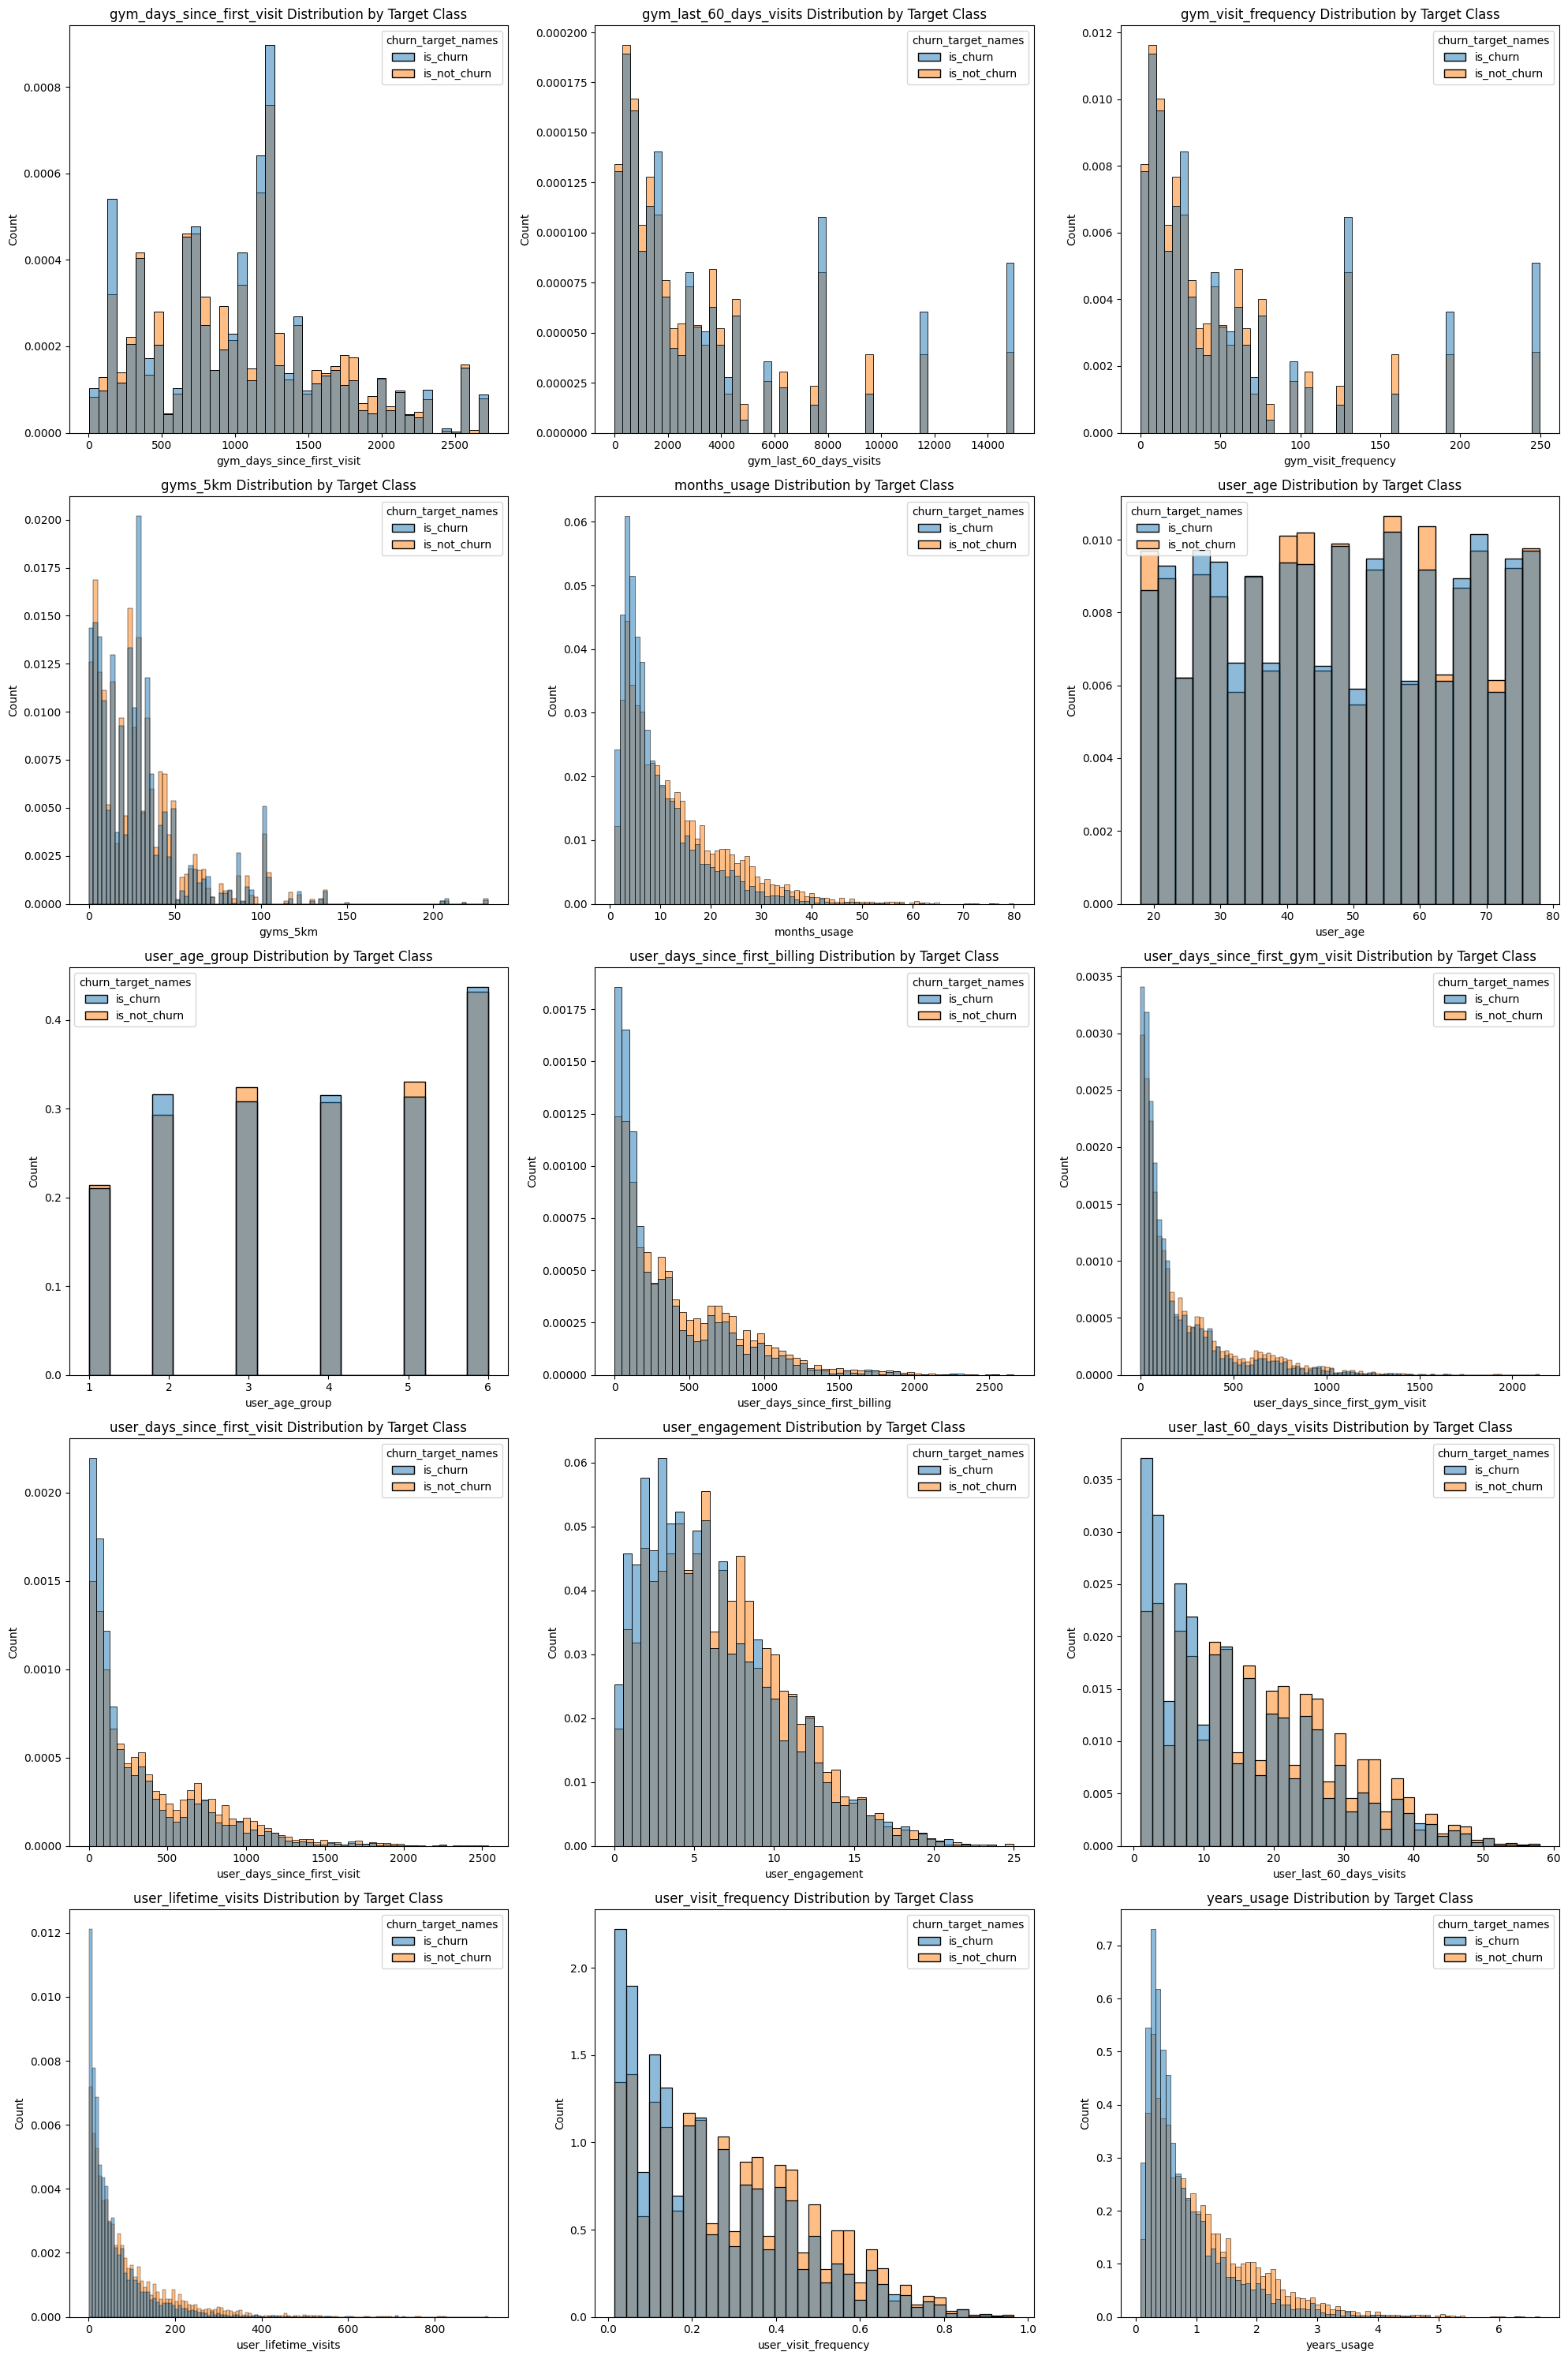

In [36]:
import math

# calculate the number of rows and columns needed for the subplots
num_vars = len(FEATURES_ANALYZE)
num_cols = 3  # adjust as needed
num_rows = math.ceil(num_vars / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows*6))

for i, numeric_var in enumerate(FEATURES_ANALYZE):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    sns.histplot(data=df_res[FEATURES_ANALYZE + ['churn_target_names']], x=numeric_var, hue='churn_target_names', ax=ax, stat='density')
    ax.set_title(f'{numeric_var} Distribution by Target Class')
    ax.set_xlabel(f"{numeric_var}")
    ax.set_ylabel('Count')

# Remove unused subplots
if num_rows * num_cols > num_vars:
    for j in range(i+1, num_rows * num_cols):
        fig.delaxes(axs.flatten()[j])


plt.tight_layout()
# Save the figure
plt.savefig('viz/numeric_features_histogram.png')
plt.show()

# Conclusions
- Imbalaced dataset
- Skewed features
- People tend to not churn
- Top churn gyms have more basic II and silver plans 
- Old people (66+) is less likely too churn
- The user frequency and recency may affects the churn
- We can combine features (user engagement) to see some separation between classes.
- Some features don't seem to help (e.g age, gyms_5k)